# Digit Recognizer

This dataset, sourced from Kaggle at "https://www.kaggle.com/competitions/digit-recognizer", provides grayscale image data for the MNIST dataset, a widely recognized standard in the field of machine learning and computer vision. The MNIST dataset, short for Modified National Institute of Standards and Technology dataset, is specifically designed for developing and evaluating machine learning models in image recognition tasks.

Key Features of the MNIST Dataset:

- Data Composition: It consists of 28x28 pixel grayscale images of handwritten digits, ranging from 0 to 9. Each image in the dataset is flattened into a row of 784 pixel values (28x28), representing the intensity of each pixel. These values typically vary from 0 (black) to 255 (white), capturing various shades of gray in between.
- Labels: Accompanying each image is a corresponding label that indicates the digit represented by the image. This labeling is crucial for supervised learning models, where the algorithm learns to correlate pixel patterns with their respective digit labels.
- Applications: MNIST is a fundamental dataset for experimenting with image processing, machine learning, and deep learning techniques. It serves as a benchmark for classification algorithms and is an essential educational tool for those new to the field.
The dataset on Kaggle is part of a competition aimed at digit recognition, challenging participants to build models that can accurately classify handwritten digits based on the provided image data. This dataset is invaluable for practitioners at all levels, offering a practical platform for honing skills in data preprocessing, model building, and evaluation within the realm of computer vision

## Pre-requisites

This section will install the required packages to the python kernel along, import the required modules and download the required data from kaggle if needed.

In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install kaggle
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
import os
import pandas as pd
import numpy as np
import kaggle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, SGD, Adam
from keras.losses import SparseCategoricalCrossentropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

In [3]:
COMPETITION_NAME = "digit-recognizer"
DATA_FOLDER = f"/kaggle/input/{COMPETITION_NAME}"
LOCAL_MACHINE = True

def download_data_local_machine():
    home = os.path.expanduser("~")
    if not os.path.exists(home + "/.kaggle/kaggle.json"):
        raise RuntimeError("Kaggle API key missing")
    if not os.path.exists(f"{COMPETITION_NAME}.zip"):
        kaggle.api.authenticate()
        kaggle.api.competition_download_files(COMPETITION_NAME)
        !unzip {COMPETITION_NAME}.zip

train_df_path = os.path.join(DATA_FOLDER, "train.csv")
test_df_path = os.path.join(DATA_FOLDER, "test.csv")
if LOCAL_MACHINE:
    #download_data_local_machine()
    train_df_path = "train.csv"
    test_df_path = "test.csv"

In [4]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

# EDA

## Structure
The DataFrame appears to have 785 columns. These columns are divided into a 'label' column and 784 'pixel' columns (pixel0 to pixel783).

## Label Column
- This column contais the the target variaof theyour dataset.
- Each entry in this column represents the actual digit that the corresponding row's image represents.
- In the first five rows shown, the labels are 1, 0, 1, 4, and 0.

## Pixel Columns
- These columns represent the individual pixels of a 28x28 pixel image, flattened into a single row. This format explains why there are 784 pixel columns (since 28 * 28 = 784).
- Each pixel column contains an integer value, typically ranging from 0 to 255, representing the pixel's intensity in a grayscl value 0).

## Data Types
- The 'label' column likely contains integer values (0-9), each corresponding to a digit.
- The 'pixel' columns also contain integers representing the grayscale intensi

## Dataset Strength
- There appears to be 42000 entries of images stored in this csv file.
- The unique values of label are the integers 0 to 9 aspected.
- There are no null value so data cleaning is not needed here. But it should be noted we should prepare this into the format we need later (ie. image data 28x28).
- The dataset appears to be very balanced between different label classifications which will help avoid bias in our model later.ty.
l value 0).

In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df.shape

(42000, 785)

In [7]:
train_df["label"].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int64)

In [8]:
print("\n----- Null counts -----")
null_counts = train_df.isna().sum()
print(null_counts)


----- Null counts -----
label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64


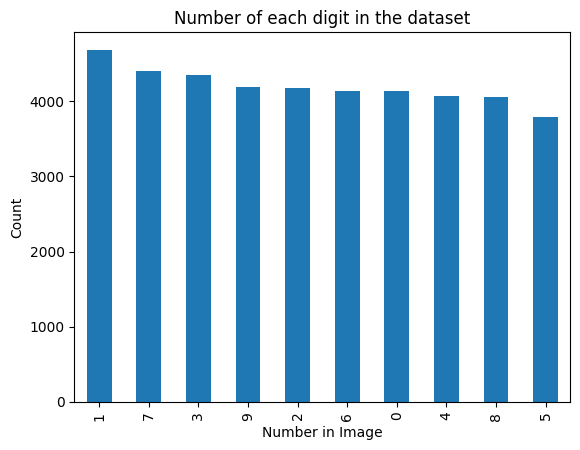

In [9]:
train_df["label"].value_counts().plot(kind="bar")
plt.xlabel("Number in Image")
plt.ylabel("Count")
plt.title("Number of each digit in the dataset")
plt.show()

## Data Preparation

### Image Reshaping
- **Constant Definition**: A constant `IMAGE_SHAPE` is defined to reshape the images. It is set to (28, 28, 1), indicating that each image will be reshaped to 28x28 pixels with a single color channel (grayscale).
  
### Function for Data Reformatting
- **`reformat_data` Function**: 
  - Drops any missing values (`dropna()`).
  - Resets the index of the DataFrame (`reset_index(drop=True)`).
  - Reshapes the data to the defined `IMAGE_SHAPE`.

### Preparing Training and Test Sets
- **Splitting Data**:
  - The target labels (`train_target`) are separated from the training dataset (`train_df`).
  - The `train_df` DataFrame is then reshaped using the `reformat_data` function to create `train_images`.
  - A similar process is followed for the test dataset to create `test_images`.
- **Train-Validation Split**:
  - The training data is further split into training and validation sets using `train_test_split`, with 20% of the data reserved for validation.
  - A `random_state` of 42 ensures reproducibility of the split.

### Data Augmentation and Generators
- **ImageDataGenerator**:
  - Three `ImageDataGenerator` instances are created for training (`TRAIN_DATAGEN`), validation (`VAL_DATAGEN`), and testing (`TEST_DATAGEN`).
  - `TRAIN_DATAGEN` includes data augmentation techniques like rotation, width and height shifts, shear, zoom, and horizontal flips.
  - `VAL_DATAGEN` and `TEST_DATAGEN` are used for rescaling the pixel values only.
- **Generators**:
  - The `generators` function creates data generators for the training, validation, and test sets.
  - These generators provide a batch of images (`batch_size` specified) and corresponding labels, with shuffling for training data and no shuffling for validation and test data.
  - A `seed` of 42 is used for reproducibility.

This preparation process ensures that the data is in the correct format for feeding into a machine learning model and includes augmentation to improve model generalization.


In [10]:
IMAGE_SHAPE = (28, 28, 1)

def reformat_data(df):
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df.values.reshape(-1, 28, 28, 1)

train_target = train_df["label"]
train_df_images = train_df.drop("label", axis=1)

train_images = reformat_data(train_df_images)
test_images = reformat_data(test_df)

train_images, validation_images, train_target, validation_target = train_test_split(
    train_images,
    train_target,
    test_size=0.2,
    random_state=42
)

TRAIN_DATAGEN = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
VAL_DATAGEN = ImageDataGenerator(rescale=1.0 / 255)
TEST_DATAGEN = ImageDataGenerator(rescale=1.0 / 255)

def generators(batch_size):
    train_generator = TRAIN_DATAGEN.flow(
        x=train_images,
        y=train_target,
        batch_size=batch_size,
        shuffle=True,
        seed=42
    )

    validation_generator = VAL_DATAGEN.flow(
        x=validation_images,
        y=validation_target,
        batch_size=batch_size,
        shuffle=False,
        seed=42
    )

    test_generator = VAL_DATAGEN.flow(
        x=test_images,
        batch_size=batch_size,
        shuffle=False,
        seed=42
    )

    return train_generator, validation_generator, test_generator

# Models and Results

## Convolutional Neural Network


### Convolutional Layers and ReLU Activation
- **Convolutional Layers**: Capture spatial patterns in images; filter sizes are adjustable for hyperparameter tuning.
- **ReLU Activation**: Introduces non-linearity, optimizing complex pattern learning.

### Batch Normalization
- **Purpose**: Stabilizes layer outputs, enhancing training speed and efficiency.

### Pooling Layer
- **Function**: Reduces data dimensionality, easing computational load. Pool size is a tunable parameter.

### Classification Layers and Softmax Activation
- **Dense Layers**: Used for final classification; number of neurons and layers can be varied.
- **Softmax Activation**: Provides a probability distribution over 10 classes, suitable for multi-class classification.

### Hyperparameter Tuning
- **Filter Size, Pool Size, Dropout Rate**: Key parameters in the model are designed to be variable, allowing for extensive hyperparameter tuning to optimize model performance.


In [11]:
def create_cnn_model_mnist(dropout_rate, filter_size, pool_size):
    model = Sequential()

    model.add(Conv2D(32, filter_size, activation='relu', input_shape=IMAGE_SHAPE))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=pool_size))
    model.add(Conv2D(64, filter_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))  # 10 units for 10 classes, 'softmax' for multi-class classification

    return model

In [12]:
def plot_training_history(history):
    # Extracting loss and accuracy values for both training and validation
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plot for training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
# List of hyperparameters
hyperparameters = [
    {
        "lr": 0.001,
        "batch_size": 32,
        "epochs": 10
    },
    {
        "lr": 0.001,
        "batch_size": 64,
        "epochs": 10
    },
    {
        "lr": 0.01,
        "batch_size": 32,
        "epochs": 10
    },
    {
        "lr": 0.01,
        "batch_size": 64,
        "epochs": 10

    },
    {
        "lr": 0.001,
        "batch_size": 32,
        "epochs": 5
    },
    {
        "lr": 0.001,
        "batch_size": 64,
        "epochs": 5
    },
    {
        "lr": 0.01,
        "batch_size": 32,
        "epochs": 5
    },
    {
        "lr": 0.01,
        "batch_size": 64,
        "epochs": 5
    }
]
histories = []
cnn_models = []
for params in hyperparameters:
    train_generator, val_generator, test_generator = generators(params["batch_size"])
    print(f"Training model with LR={params['lr']}, Batch Size={params['batch_size']}, Epochs={params['epochs']}")

    # Create and compile the model
    model = create_cnn_model_mnist(dropout_rate=0.1, filter_size=(3, 3), pool_size=(2, 2))
    model.compile(optimizer=Adam(learning_rate=params["lr"]),
                    loss=SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=params["epochs"],
        validation_data=val_generator,
        validation_steps=val_generator.n // val_generator.batch_size
    )

    histories.append(history)
    cnn_models.append(model)

Training model with LR=0.001, Batch Size=32, Epochs=10


Epoch 1/10


1050/1050 [==============================] - 13s 11ms/step - loss: 1.0417 - accuracy: 0.6412 - val_loss: 0.4213 - val_accuracy: 0.8635
Epoch 2/10
1050/1050 [==============================] - 11s 11ms/step - loss: 0.5571 - accuracy: 0.8165 - val_loss: 0.3131 - val_accuracy: 0.8987
Epoch 3/10
1050/1050 [==============================] - 11s 11ms/step - loss: 0.4249 - accuracy: 0.8654 - val_loss: 0.1681 - val_accuracy: 0.9482
Epoch 4/10
1050/1050 [==============================] - 11s 10ms/step - loss: 0.3567 - accuracy: 0.8874 - val_loss: 0.1743 - val_accuracy: 0.9463
Epoch 5/10
1050/1050 [==============================] - 11s 10ms/step - loss: 0.3209 - accuracy: 0.9006 - val_loss: 0.1929 - val_accuracy: 0.9371
Epoch 6/10
1050/1050 [==============================] - 11s 10ms/step - loss: 0.2946 - accuracy: 0.9093 - val_loss: 0.1698 - val_accuracy: 0.9510
Epoch 7/10
1050/1050 [==============================] - 11s 10ms/

LR=0.001_BS=32_Epochs=10


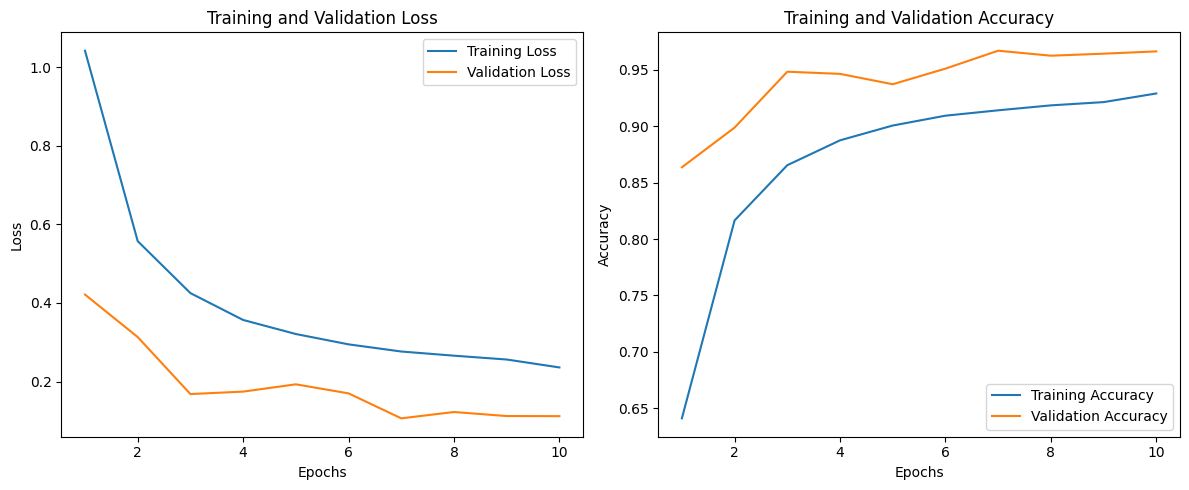

LR=0.001_BS=64_Epochs=10


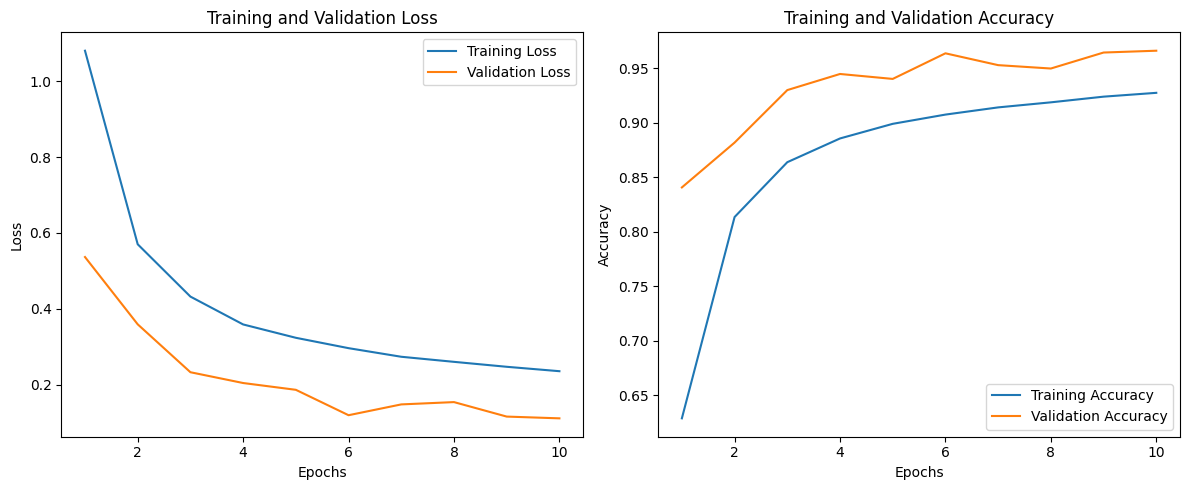

LR=0.01_BS=32_Epochs=10


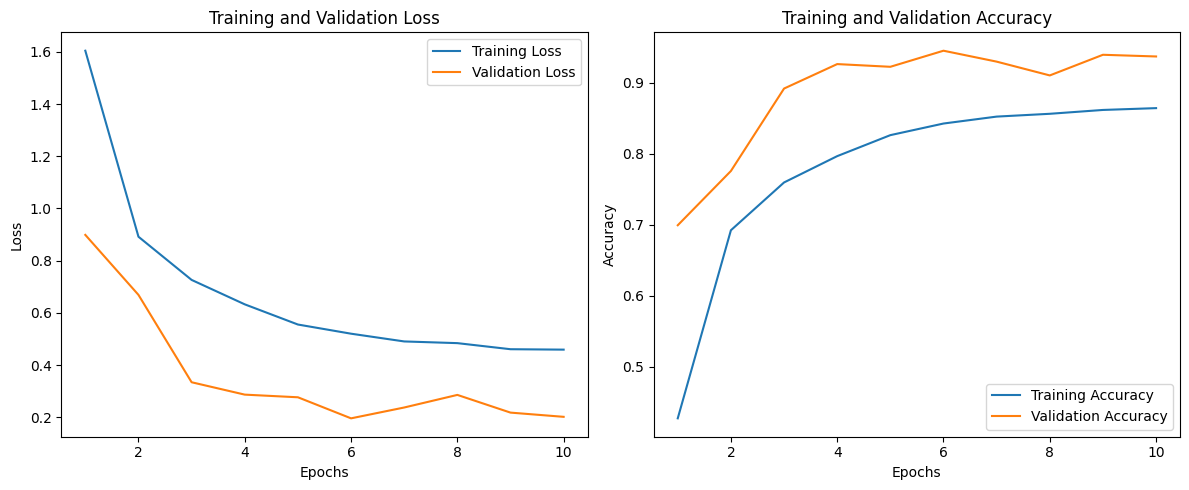

LR=0.01_BS=64_Epochs=10


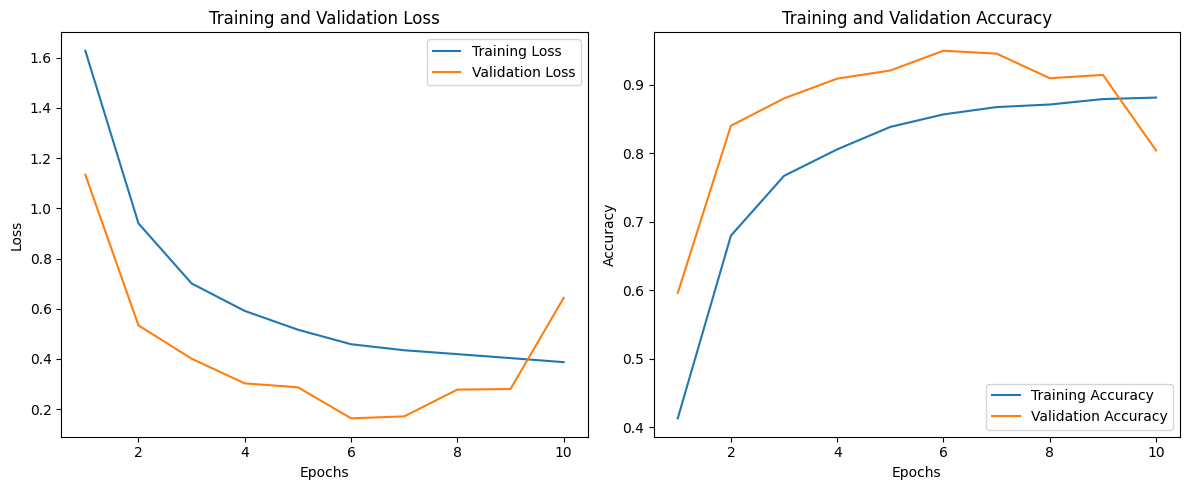

LR=0.001_BS=32_Epochs=5


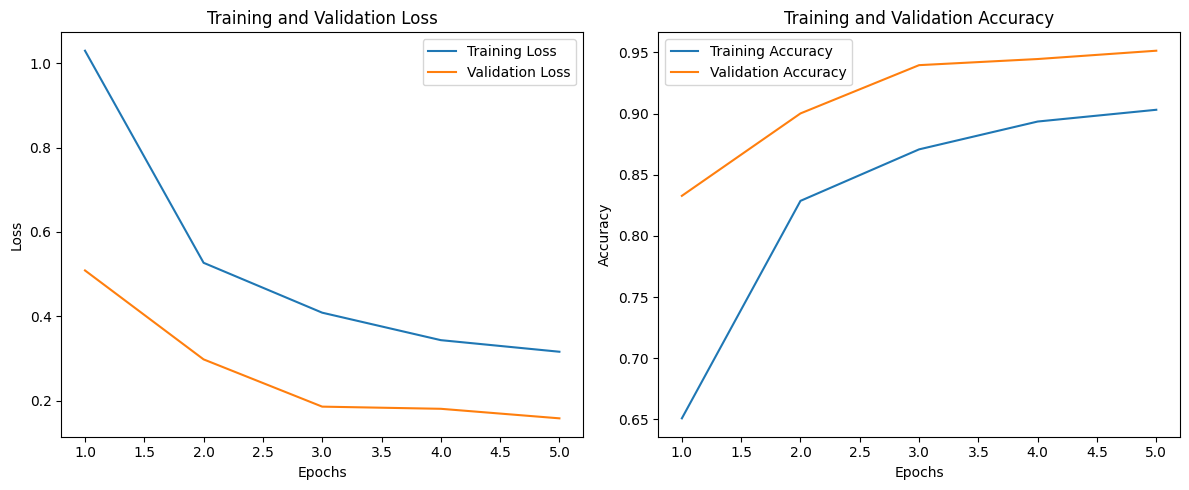

LR=0.001_BS=64_Epochs=5


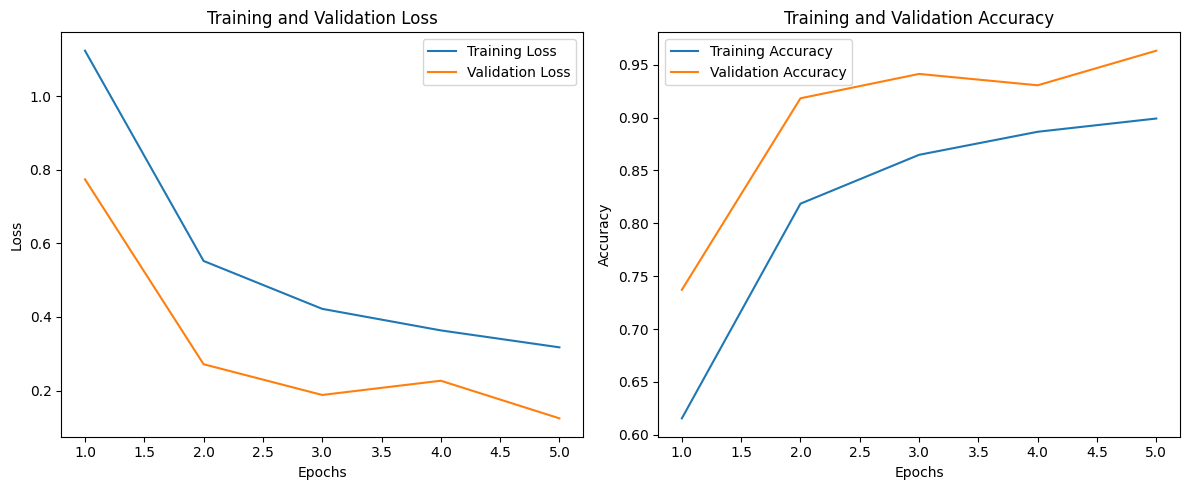

LR=0.01_BS=32_Epochs=5


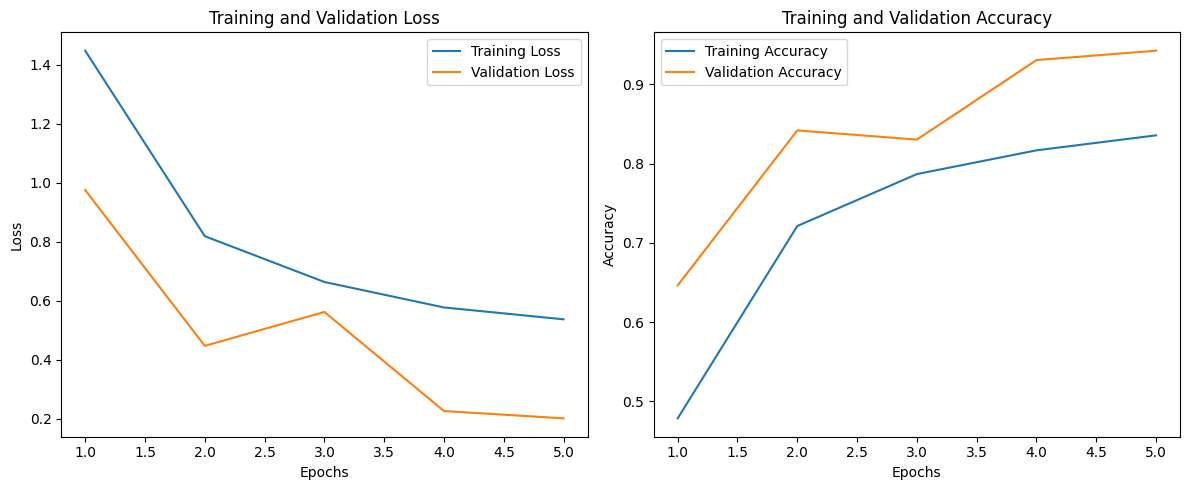

LR=0.01_BS=64_Epochs=5


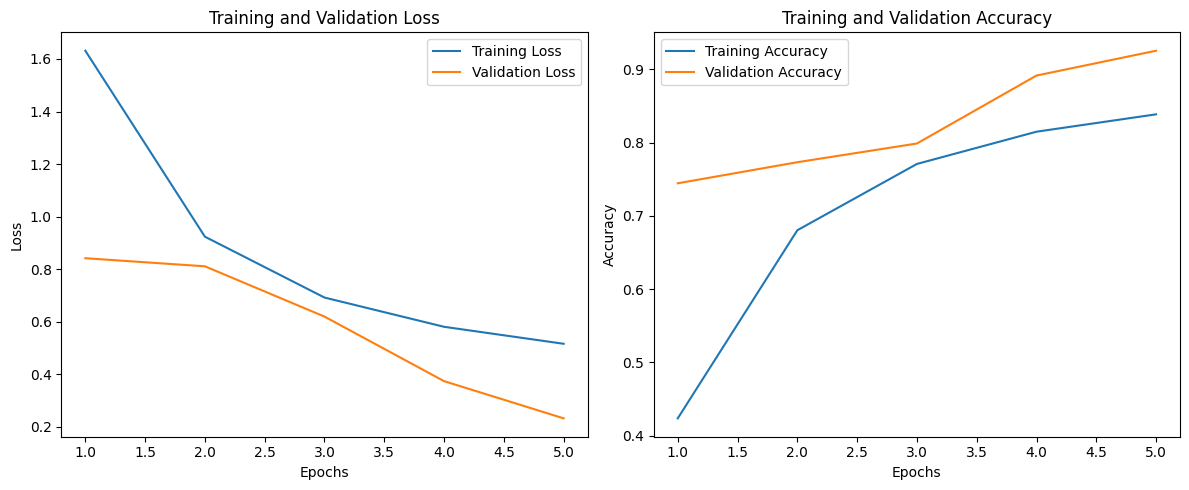

In [14]:
# Plot training history
model_names = []
for i in range(len(hyperparameters)):
    model_name = f"LR={hyperparameters[i]['lr']}_BS={hyperparameters[i]['batch_size']}_Epochs={hyperparameters[i]['epochs']}"
    model_names.append(model_name)
    print(model_name)
    plot_training_history(histories[i])

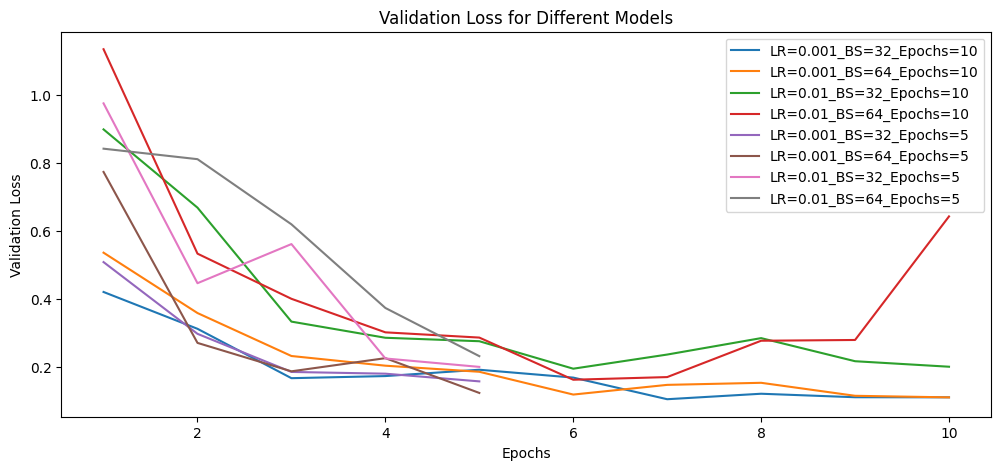

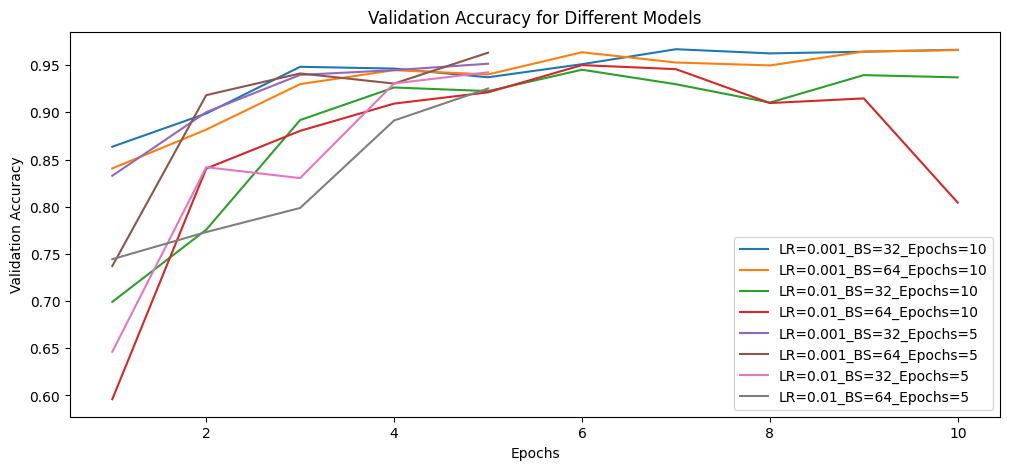

In [15]:
# Lists to store validation loss and accuracy for all models
validation_losses = []
validation_accuracies = []

# Assuming you have a list of hyperparameters and histories
for i in range(len(hyperparameters)):
    # Extract validation loss and accuracy for the current model
    val_loss = histories[i].history['val_loss']
    val_acc = histories[i].history['val_accuracy']
    
    validation_losses.append(val_loss)
    validation_accuracies.append(val_acc)

# Plot all models' validation loss on one plot
plt.figure(figsize=(12, 5))
for i in range(len(validation_losses)):
    plt.plot(range(1, len(validation_losses[i]) + 1), validation_losses[i], label=model_names[i])
plt.title('Validation Loss for Different Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Plot all models' validation accuracy on one plot
plt.figure(figsize=(12, 5))
for i in range(len(validation_accuracies)):
    plt.plot(range(1, len(validation_accuracies[i]) + 1), validation_accuracies[i], label=model_names[i])
plt.title('Validation Accuracy for Different Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [16]:
final_validation_losses = [losses[-1] for losses in validation_losses]
final_validation_accuracies = [losses[-1] for losses in validation_accuracies]

# Find the model with the lowest validation loss
min_loss_index = np.argmin(final_validation_losses)
min_loss = validation_losses[min_loss_index]

# Find the model with the highest validation accuracy
max_accuracy_index = np.argmax(final_validation_accuracies)
max_accuracy = validation_accuracies[max_accuracy_index]

# Checking if the best loss and best accuracy belong to the same model
if min_loss_index == max_accuracy_index:
    best_model_index = min_loss_index  # or max_accuracy_index, since they are equal
else:
    # If not, prioritize accuracy
    best_model_index = max_accuracy_index

best_cnn_model = cnn_models[best_model_index]
print(f"The best model index is: {best_model_index}")
print(f"Best Model Loss: {final_validation_losses[best_model_index]}")
print(f"Best Model Accuracy: {final_validation_accuracies[best_model_index] * 100:.2f}%")

The best model index is: 0
Best Model Loss: 0.11189741641283035
Best Model Accuracy: 96.62%


## Random Forest Classifier


### Flattening Image Data
- **Preparation**: The image data is flattened before being fed into the Random Forest Classifier. Each image is converted from a 28x28 pixel matrix to a 1D array.
- **Reason**: Traditional classifiers like RFC require input data in a vector format rather than in multi-dimensional arrays typical for images.

### Using Random Forest Classifier
- **Choice of RFC**: Random Forest is a robust, ensemble learning method, effective for classification tasks. It builds multiple decision trees and merges them together to get a more accurate and stable prediction.
- **Advantages**:
  - **Versatility**: Capable of handling both regression and classification tasks.
  - **Robustness to Overfitting**: Due to averaging several trees, it tends to overfit less compared to other algorithms.
  - **Importance of Features**: RFC can rank the importance of features, which can be insightful in understanding the dataset.
- **Implementation**: 
  - A RandomForestClassifier with 100 trees (`n_estimators=100`) is used.
  - `random_state` is set to 42 for reproducibility of results.
- **Training**: The classifier is trained on the flattened training images with their corresponding labels.

RFC offers a contrasting approach to CNNs, providing insights into the dataset's feature importance and often requiring less preprocessing of image data.


In [17]:
# Flatten the image data for traditional classifiers
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
validation_images_flattened = validation_images.reshape(validation_images.shape[0], -1)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_history = rf_classifier.fit(train_images_flattened, train_target)

RFC Model Accuracy: 96.29%


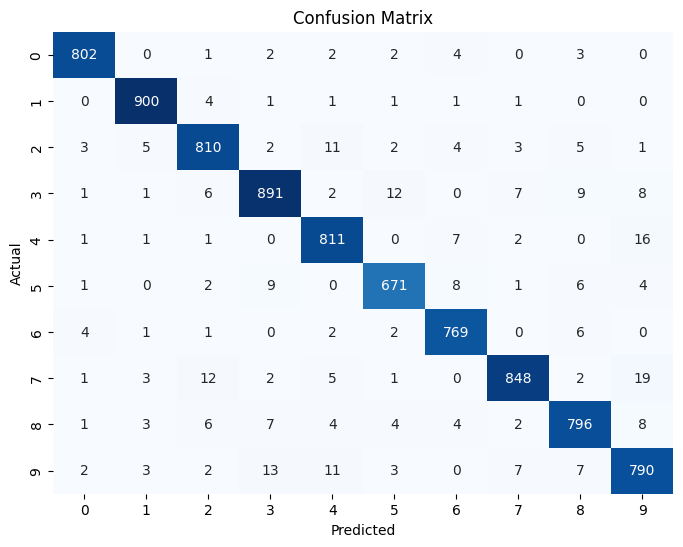

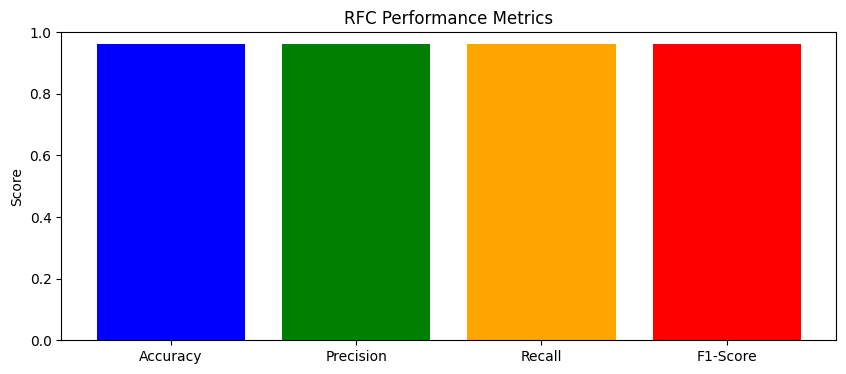

In [18]:
# Make predictions on the validation set
rf_predictions = rf_classifier.predict(validation_images_flattened)
# Calculate evaluation metrics
accuracy = accuracy_score(validation_target, rf_predictions)
print(f"RFC Model Accuracy: {accuracy * 100:.2f}%")
precision = precision_score(validation_target, rf_predictions, average='weighted')
recall = recall_score(validation_target, rf_predictions, average='weighted')
f1 = f1_score(validation_target, rf_predictions, average='weighted')
conf_matrix = confusion_matrix(validation_target, rf_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot other metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 4))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1.0)
plt.title("RFC Performance Metrics")
plt.ylabel("Score")
plt.show()


## Ensemble Method: Combining CNN and RFC Predictions


### Ensemble Predictions Function
- **Purpose**: The `ensemble_predictions` function combines the strengths of both the CNN and Random Forest Classifier to make more accurate predictions.
- **Process**:
  - **CNN Predictions**: First, predictions are obtained from the CNN model using the validation generator.
  - **RFC Predictions**: Simultaneously, predictions are made using the Random Forest Classifier on the flattened validation images.
  - **Combining Predictions**: The predictions from both models are combined. The CNN's predictions, initially in a one-hot encoded format, are converted to label encoded format using `np.argmax`.
  - **Final Decision**: The final prediction for each image is determined by calculating the mode (most common prediction) across the predictions from both models.

### Implementation in Ensemble
- **CNN Model**: A pre-trained and optimized CNN model is used for making part of the predictions.
- **Random Forest Classifier**: The RFC, already trained on the flattened image data, complements the CNN's predictions.
- **Validation Data**: Both models make predictions on the same validation dataset, ensuring consistency in comparison.

### Benefits of Ensemble Approach
- **Accuracy**: Combining the predictions of two different types of models (a deep learning model and a traditional machine learning model) can lead to more accurate overall predictions.
- **Strengths of Both Models**: This approach leverages the CNN's ability to capture complex patterns in image data and the RFC's robustness and feature importance insights.

By using an ensemble of CNN and RFC, the method capitalizes on the diverse strengths of these models, potentially leading to better performance than using either model alone.


In [20]:
def ensemble_predictions(cnn_model, rf_classifier, val_generator, validation_images_flattened):
    # Make predictions using the CNN model
    cnn_predictions = cnn_model.predict(val_generator)
    
    # Make predictions using the Random Forest Classifier
    rf_predictions = rf_classifier.predict(validation_images_flattened)

    # Convert CNN predictions from one-hot encoded to label encoded
    cnn_predictions = np.argmax(cnn_predictions, axis=1)

    # Combine predictions vertically
    combined_predictions = np.vstack((cnn_predictions, rf_predictions))

    # Calculate the mode of predictions (most common prediction)
    final_predictions, _ = mode(combined_predictions, axis=0)
    final_predictions = final_predictions.flatten()  # Flatten the array to match the target's shape

    return final_predictions
    
final_predictions = ensemble_predictions(best_cnn_model, rf_classifier, val_generator, validation_images_flattened)

132/132 [==============================] - 1s 5ms/step


Ensemble Model Accuracy: 96.23%


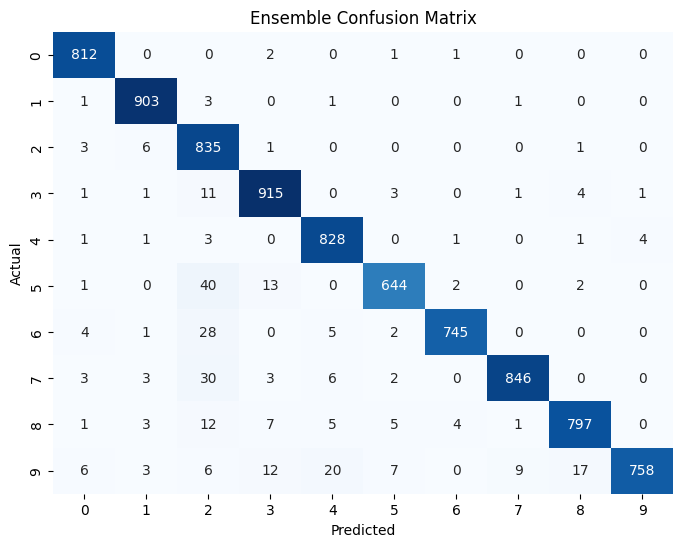

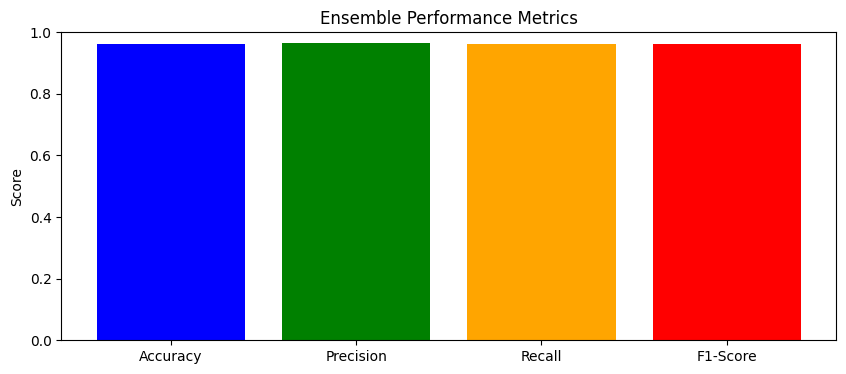

In [21]:
# Calculate accuracy
ensemble_accuracy = accuracy_score(validation_target, final_predictions)
print(f"Ensemble Model Accuracy: {ensemble_accuracy * 100:.2f}%")

# Calculate other metrics
ensemble_precision = precision_score(validation_target, final_predictions, average='weighted')
ensemble_recall = recall_score(validation_target, final_predictions, average='weighted')
ensemble_f1 = f1_score(validation_target, final_predictions, average='weighted')
ensemble_conf_matrix = confusion_matrix(validation_target, final_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Confusion Matrix")
plt.show()

# Plot other metrics
ensemble_metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
ensemble_values = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1]

plt.figure(figsize=(10, 4))
plt.bar(ensemble_metrics, ensemble_values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1.0)
plt.title("Ensemble Performance Metrics")
plt.ylabel("Score")
plt.show()

# Discussions and Conclusions


### Overview of Model Performance
- In our exploration of various models for digit recognition on the MNIST dataset, we observed that a specific CNN configuration (learning rate: 0.001, batch size: 32, 10 epochs) marginally outperformed other models.
- This comparison encompassed several variations of CNN architectures, a traditional machine learning approach using Random Forest Classifier (RFC), and an innovative ensemble method combining the strengths of both CNN and RFC.
- Notably, the performance differences between our best CNN model and the other approaches were minimal, indicating a level of parity in effectiveness across these diverse methodologies.

### Detailed Insights and Potential Enhancements
1. **Optimization Strategies**:
   - **RFC and Ensemble Models**: While these models demonstrated competence, optimizing their hyperparameters could unlock further potential. For the RFC, exploring different numbers of trees, tree depths, and split criteria could be beneficial. In the ensemble model, refining how CNN and RFC predictions are integrated could lead to a more robust decision-making process.
   - **CNN Training Duration**: Given the absence of overfitting signs in the CNN models, extending the training duration could be advantageous. Methodical increments in the number of epochs, while continuously monitoring the model's performance on validation data, could help in achieving a more optimal balance between bias and variance.

2. **Model Selection and Computational Considerations**:
   - Although the CNN model slightly edged out its competitors, selecting the 'right' model is not solely about performance metrics. Factors such as computational efficiency, ease of implementation, and scalability play crucial roles, especially in different application contexts.
   - For instance, RFC, with its inherent simplicity and interpretability, might be preferred in scenarios where model explainability is paramount.

3. **Future Exploration Directions**:
   - **Advanced CNN Architectures**: Investigating more complex CNN structures, such as deeper networks or architectures with residual connections, could yield interesting results.
   - **Dataset Augmentation and Diversification**: Experimenting with augmented data or integrating additional datasets could enhance the models' ability to generalize and perform well on unseen data.
   - **Hyperparameter Tuning Techniques**: Employing systematic hyperparameter tuning techniques like grid search or Bayesian optimization for both CNN and RFC models could lead to significant improvements.

### Concluding Thoughts
- The marginal superiority of the CNN model underscores the importance of a nuanced approach to model selection, where performance metrics are just one piece of the puzzle.
- Our journey in comparing these diverse models highlights the rich possibilities in the field of machine learning and encourages a continual quest for improvement, whether through refining existing models or innovating new approaches.
- In conclusion, the field of digit recognition, and more broadly, image classification, remains an exciting area with ample opportunities for exploration and advancement.


# Submission
Finally, submitting our best model to kaggle.

In [22]:
# Make predictions using the best CNN model
cnn_predictions = best_cnn_model.predict(test_generator)

# Convert CNN predictions from one-hot encoded to label encoded
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Create a DataFrame for submission
results_df = pd.DataFrame({"ImageId": range(1, len(cnn_predictions) + 1), "Label": cnn_predictions})

# Save the DataFrame to a CSV file for submission
results_df.to_csv("submission.csv", index=False)

438/438 [==============================] - 2s 5ms/step
